In [2]:
import pystac_client
from odc.stac import load
from datetime import datetime, timedelta, timezone
from dask.distributed import Client as DaskClient
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dask_client = DaskClient()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 9.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37553,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40013,Total threads: 2
Dashboard: http://127.0.0.1:46023/status,Memory: 2.40 GiB
Nanny: tcp://127.0.0.1:43771,


In [4]:
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")
collection = "sentinel-2-l2a"
min_lon = -111.9022993760827
min_lat = 41.70666265631902
max_lon = -111.89037366761869
max_lat = 41.71517317089591
bbox = f"{min_lon},{min_lat},{max_lon},{max_lat}"
start_date = (datetime.now(timezone.utc) - timedelta(days=75)).strftime(
    "%Y-%m-%dT%H:%M:%SZ"
)
end_date = datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ")

In [5]:
search = catalog.search(
    collections=[collection],
    bbox=bbox,
    datetime=f"{start_date}/{end_date}",
)
items = search.item_collection()

In [6]:
len(items)

31

In [7]:
data = load(
    items,
    bands=["red", "nir", "scl"],
    bbox=[min_lon, min_lat, max_lon, max_lat],
    chunks={"time": 1, "x": 2048, "y": 2048},
    groupby="solar_day",
)

In [8]:
data

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 96, x: 101, time: 27)
Coordinates:
  * y            (y) float64 768B 4.619e+06 4.619e+06 ... 4.618e+06 4.618e+06
  * x            (x) float64 808B 4.249e+05 4.249e+05 ... 4.259e+05 4.259e+05
    spatial_ref  int32 4B 32612
  * time         (time) datetime64[ns] 216B 2025-03-29T18:22:47.015000 ... 20...
Data variables:
    red          (time, y, x) uint16 524kB dask.array<chunksize=(1, 96, 101), meta=np.ndarray>
    nir          (time, y, x) uint16 524kB dask.array<chunksize=(1, 96, 101), meta=np.ndarray>
    scl          (time, y, x) uint8 262kB dask.array<chunksize=(1, 96, 101), meta=np.ndarray>

In [9]:
# use scl to mask cloud, cloud shadows, nodata
mask = data["scl"].isin([0, 1, 3, 7, 8, 9, 10])

In [10]:
data_masked = data.where(~mask, other=np.nan)

In [11]:
ndvi = (data_masked.nir - data_masked.red) / (data_masked.nir + data_masked.red)
data_masked["ndvi"] = ndvi.clip(-1, 1)
data_masked = data_masked.drop_vars(["red", "nir", "scl"])

In [12]:
data_masked

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 96, x: 101, time: 27)
Coordinates:
  * y            (y) float64 768B 4.619e+06 4.619e+06 ... 4.618e+06 4.618e+06
  * x            (x) float64 808B 4.249e+05 4.249e+05 ... 4.259e+05 4.259e+05
    spatial_ref  int32 4B 32612
  * time         (time) datetime64[ns] 216B 2025-03-29T18:22:47.015000 ... 20...
Data variables:
    ndvi         (time, y, x) float64 2MB dask.array<chunksize=(1, 96, 101), meta=np.ndarray>

In [15]:
computed = data_masked.ndvi.compute()

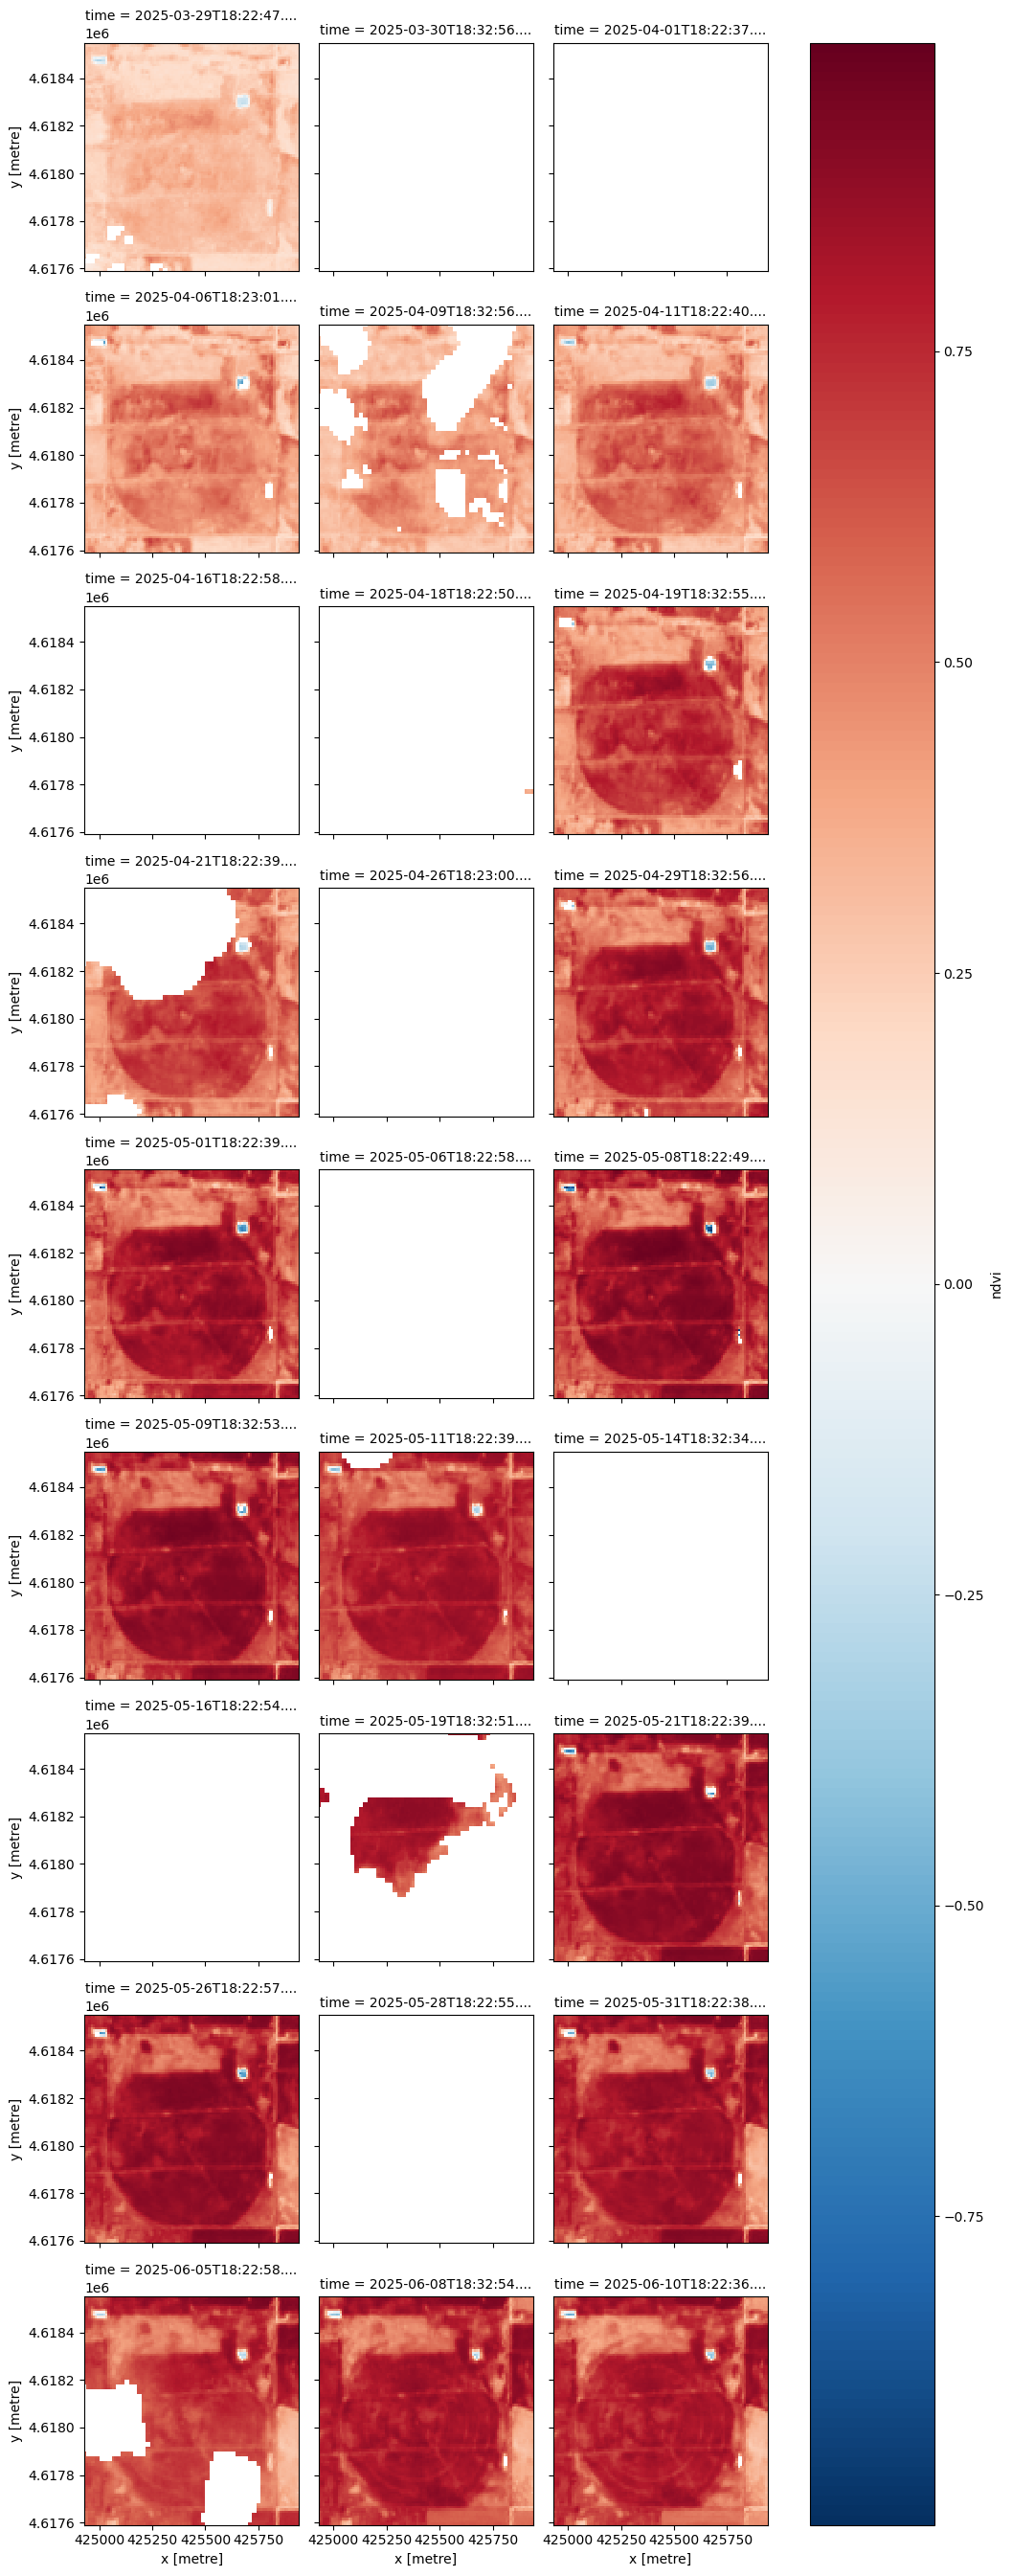

In [17]:
computed.plot(col="time", col_wrap=3)

In [18]:
resampled = computed.resample(time="5D").mean()

In [19]:
resampled_filled = (
    resampled.interpolate_na("time", method="linear").bfill("time").ffill("time")
)

In [20]:
smoothed = resampled_filled.rolling(time=3, center=True).mean()

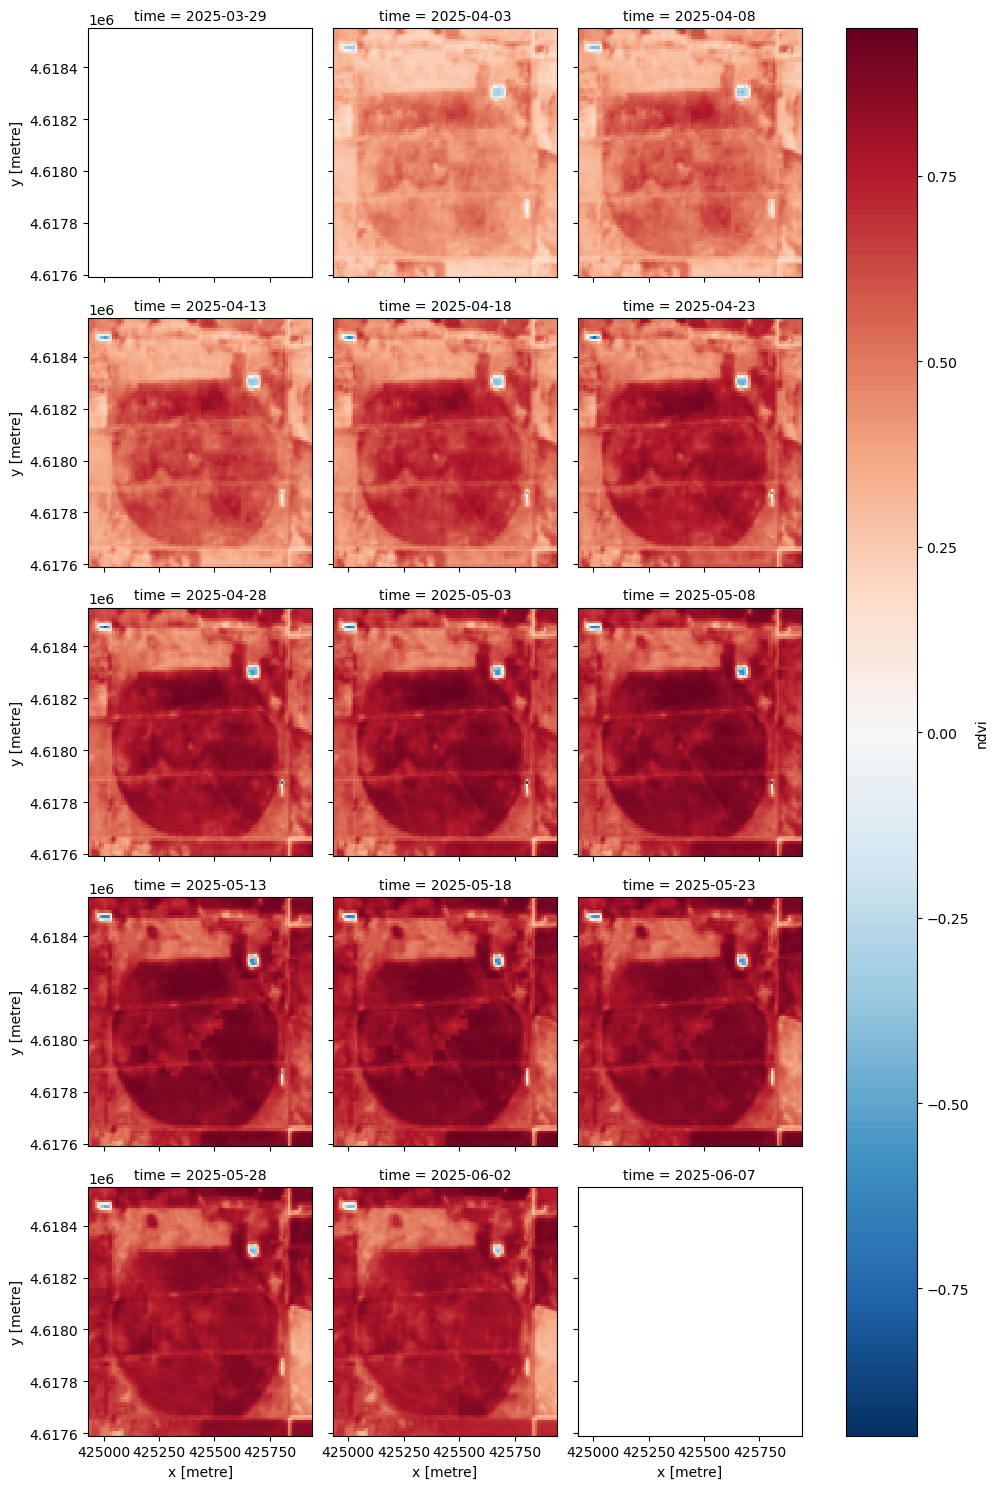

In [21]:
smoothed.plot(col="time", col_wrap=3)

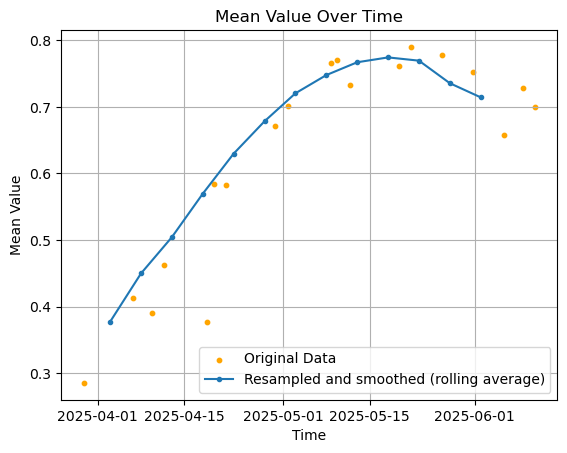

In [22]:
computed_mean = computed.mean(dim=["x", "y"])
smoothed_mean = smoothed.mean(dim=["x", "y"])

plt.scatter(
    computed_mean["time"].values,
    computed_mean.values,
    s=10,
    color="orange",
    label="Original Data",
)
plt.plot(
    smoothed_mean["time"].values,
    smoothed_mean.values,
    marker=".",
    label="Resampled and smoothed (rolling average)",
)
plt.title("Mean Value Over Time")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()